In [3]:
import pdb
import numpy as np
import random
import math
import argparse
import tensorflow as tf 
import matplotlib.pyplot as plt

from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU

from shutil import copyfile
import scipy
from sklearn.model_selection import train_test_split

#### Make Data

In [27]:
# Train Y value
def get_Sin_Data(count, a, b, c=0, d=0, y_clip=None):
    
    #X_data = 2 * np.pi / b * cycle / count * np.arange(base, count)
    X_data = np.sort(np.random.uniform(Minimum, Maximum, size=(count,1)))
    Y_data = a * np.sin(b*X_data + c) + d
    
    if y_clip != None:
        idx = np.where(np.logical_and(y_clip[0] <= Y_data, Y_data<=y_clip[1]))
        X_data = X_data[idx]
        Y_data = Y_data[idx]
        
    return X_data, Y_data

In [21]:
def plotLoss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plotSinData(a, b, c, d):
    
    x = np.arange(Minimum, Maximum ,0.1)   # start,stop,step
    y = a* np.sin(b*x + c) +d
    plt.plot(x,y, 'y.--', alpha = 0.5)
    
def plotData(X_data, Y_data, data_period, params=None, model=None, title_name=None):
    
    plt.figure(figsize=(20,10))
    
    X_data = np.squeeze(X_data.copy())
    Y_data = np.squeeze(Y_data.copy())
    idx = np.argsort(X_data)
    X_data = X_data[idx]
    Y_data = Y_data[idx]
    
    plotSinData(params['a'], params['b'], params['c'], params['d'])
        
    plt.scatter(X_data, Y_data, color='violet', label="target")
        
    if model is not None:
        plt.scatter(X_data, model.predict(X_data%data_period), color='blue', label="output")
    plt.legend()
    if title_name is not None:
        plt.title(title_name)
    plt.show()

#### Model

In [22]:
def buildFCModel(input_shape,
                 hidden_layers=4,
                 hidden_neurons=128,
                 lr=0.0001):
    
    model = tf.keras.Sequential()
    model.add(Dense(hidden_neurons, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.03))
    
    for _ in range(hidden_layers):
        model.add(Dense(hidden_neurons))
        model.add(LeakyReLU(alpha=0.03))
    
    model.add(Dense(1))

    model.compile(loss='mse', optimizer=Adam(lr=lr))
    #model.summary()
    
    board = TensorBoard(log_dir='model', histogram_freq=1, write_graph=True, write_images=False)
    board.set_model(model)
    
    return model, board

### y=sinx 데이터 생성에 변형주기

In [23]:
hidden_layers = [2, 4, 8, 16]
hidden_neurons = [32, 64, 128, 256]

In [24]:
portions = [random.randint(0,20) for _ in range(4)]
total = sum(portions)
print(portions, total)
for i in range(len(portions)):
    portions[i] /= total
print(portions)

[18, 8, 1, 0] 27
[0.6666666666666666, 0.2962962962962963, 0.037037037037037035, 0.0]


In [25]:
def mixed_data(count, portions):
    clipped = np.arange(-1, 1.5, 0.5)
    
    X_data=None; Y_data=None
    
    for i in range(4):
        x_data, y_data = get_Sin_Data(count=count, a=1, b=1, c=0, d=0, y_clip = [clipped[i], clipped[i+1]])
        x_data = x_data[:int(count*portions[i])]
        y_data = y_data[:int(count*portions[i])]
        
        if X_data is None:
            X_data = x_data
            Y_data = y_data
        else:
            X_data = np.append(X_data, x_data, axis=0)
            Y_data = np.append(Y_data, y_data, axis=0)
            
    return X_data, Y_data

[0.07, 0.32, 0.31, 0.29]


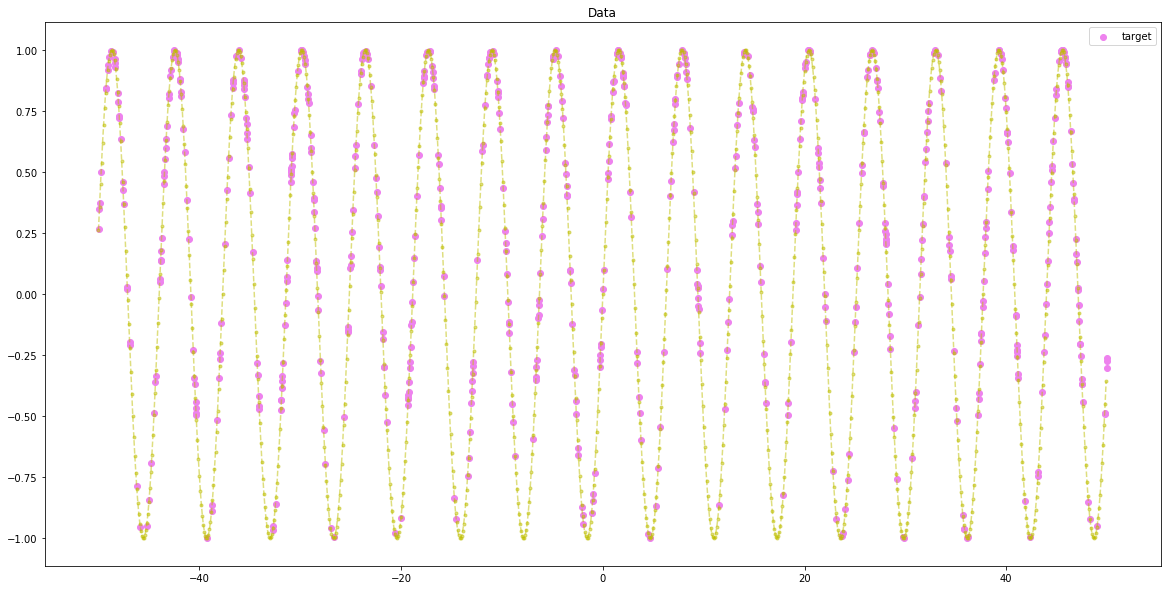

[0.34, 0.34, 0.16, 0.16]


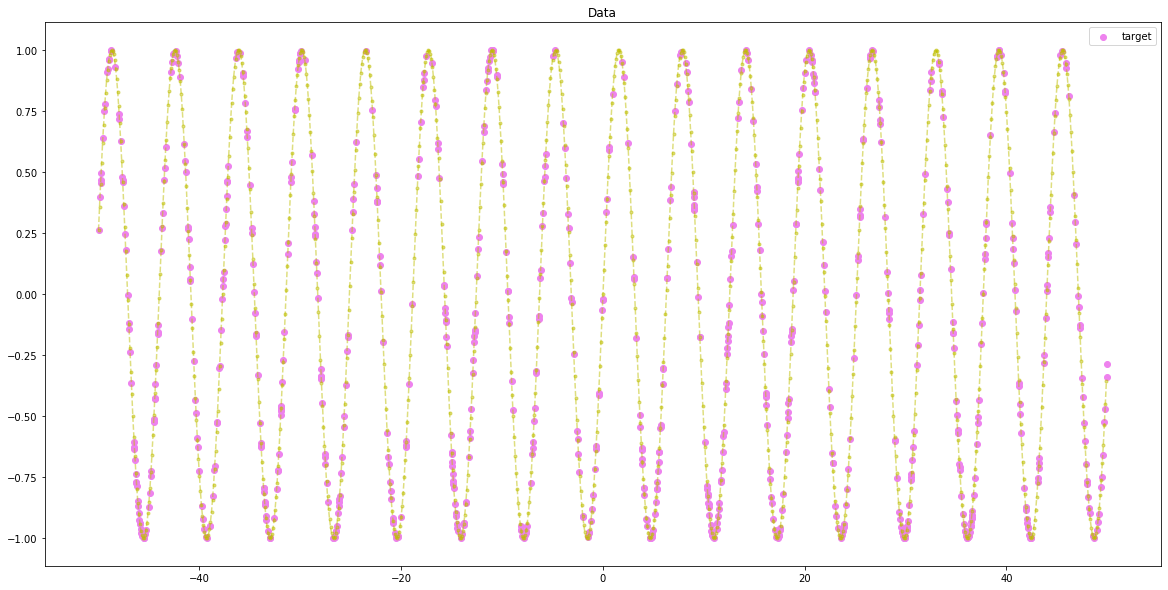

[0.11, 0.36, 0.11, 0.43]


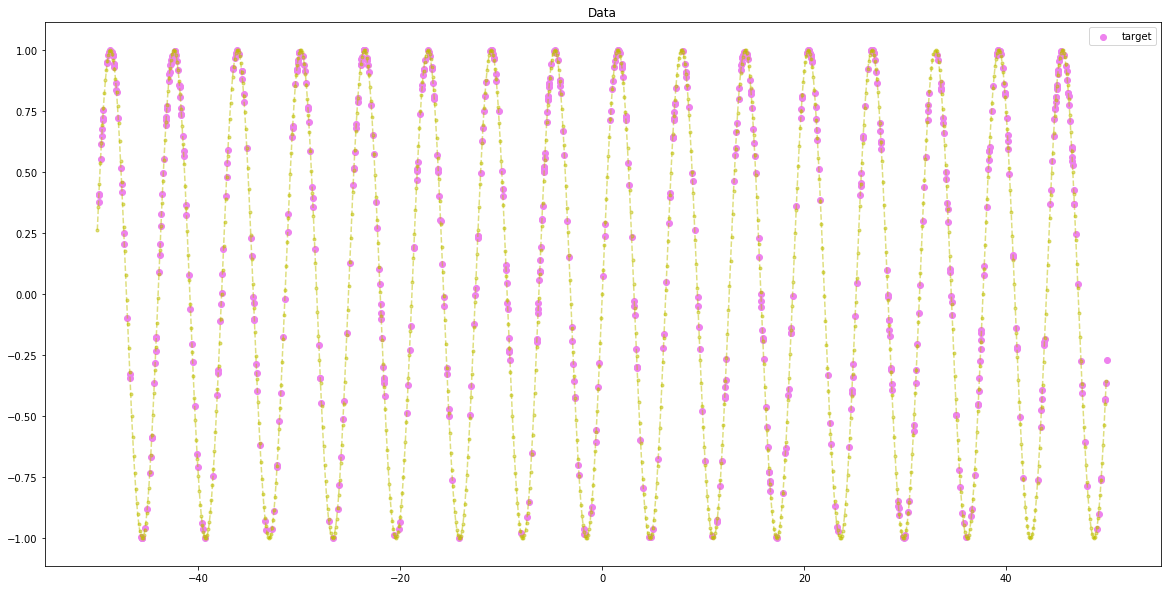

[0.23, 0.47, 0.27, 0.04]


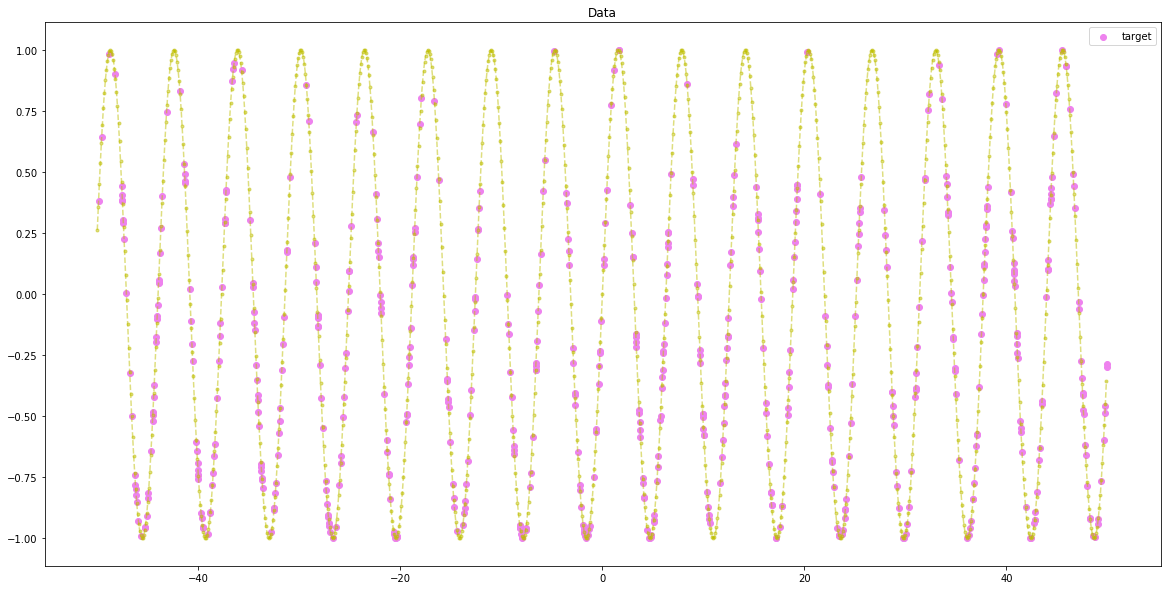

[0.09, 0.52, 0.24, 0.15]


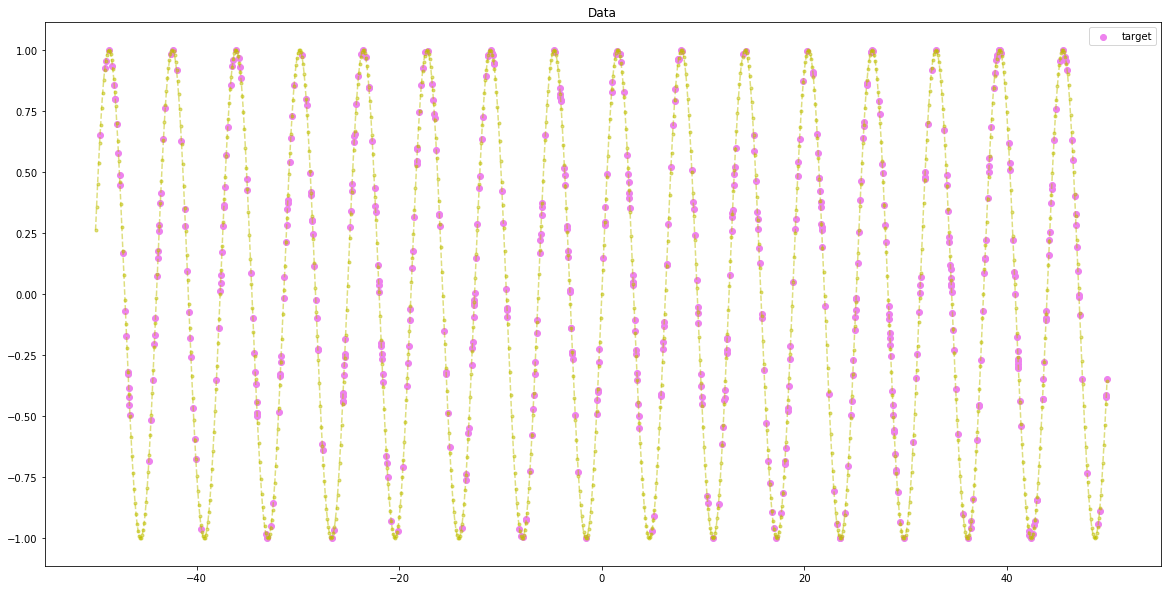

[0.04, 0.41, 0.28, 0.26]


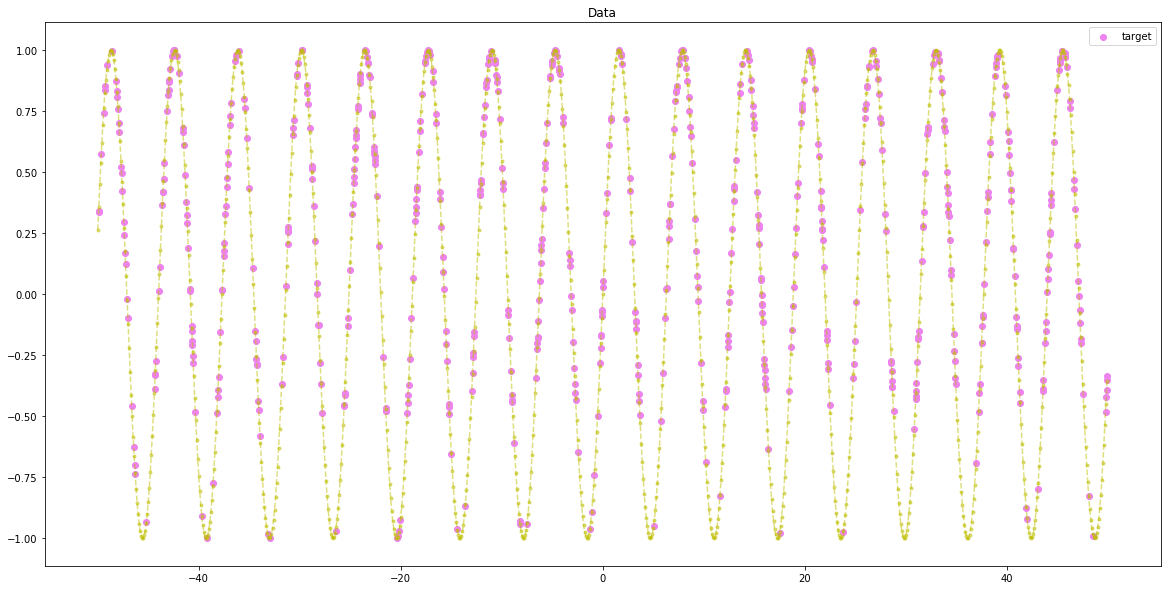

[0.42, 0.18, 0.19, 0.21]


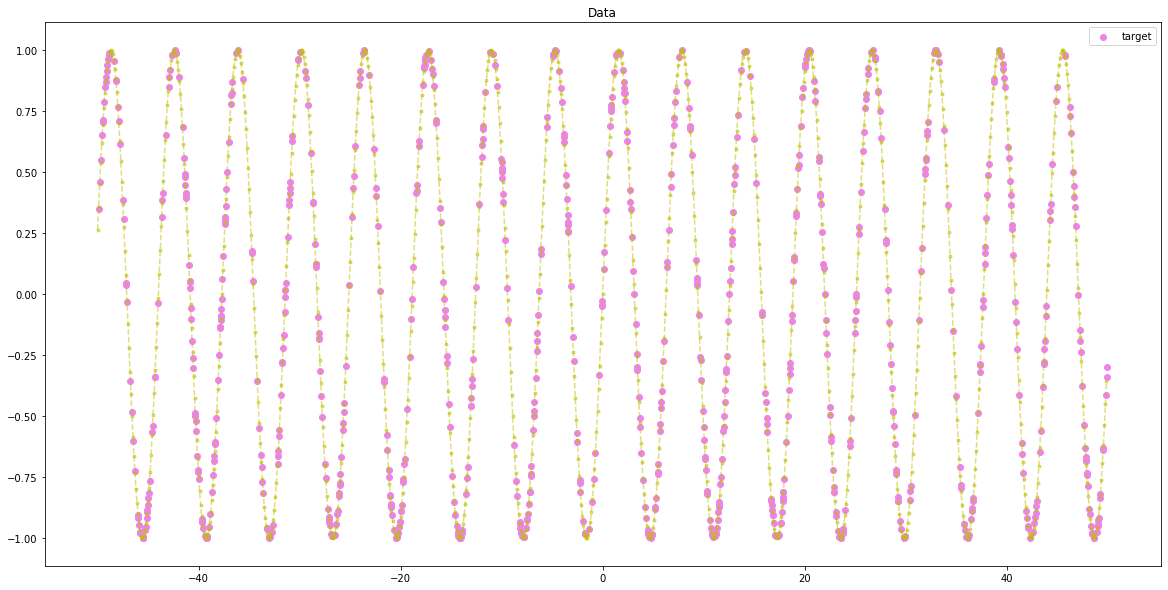

[0.14, 0.06, 0.39, 0.42]


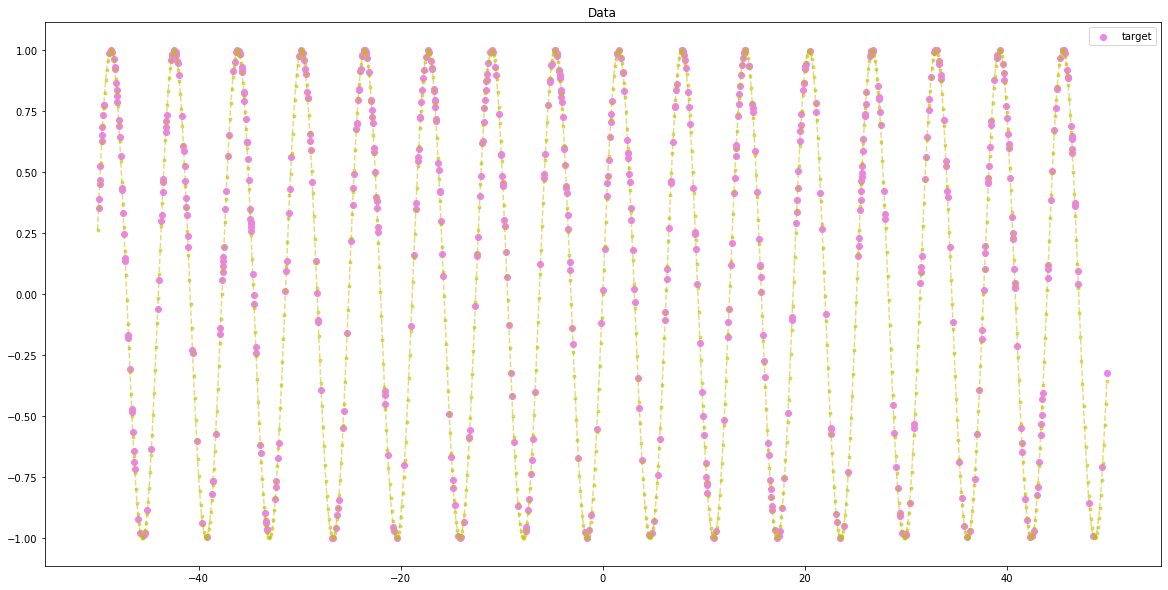

[0.36, 0.15, 0.33, 0.17]


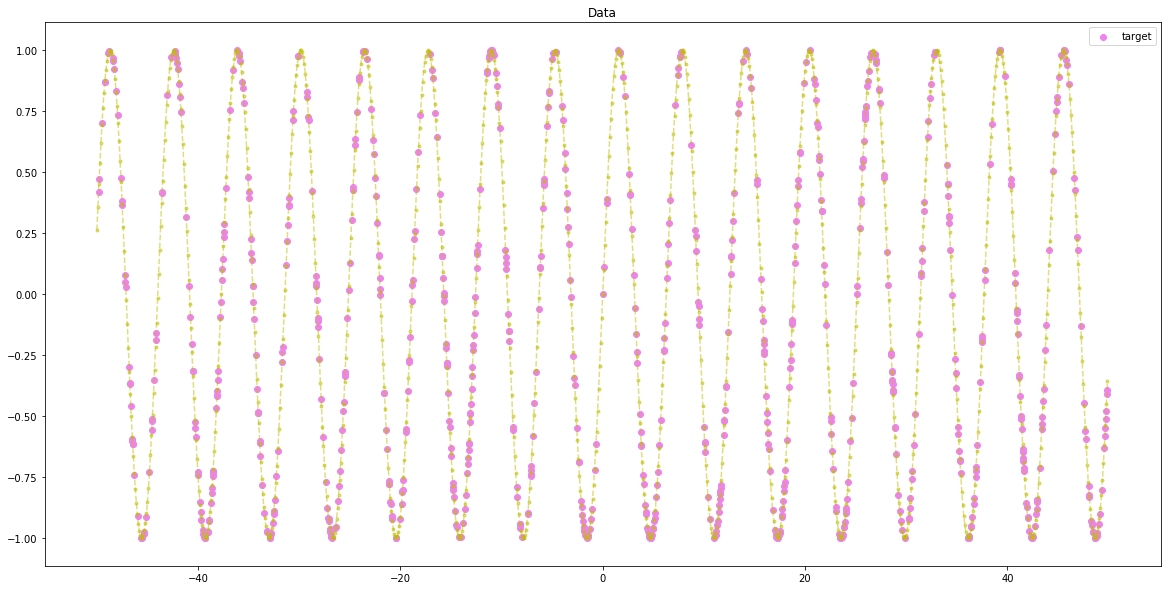

[0.27, 0.14, 0.05, 0.54]


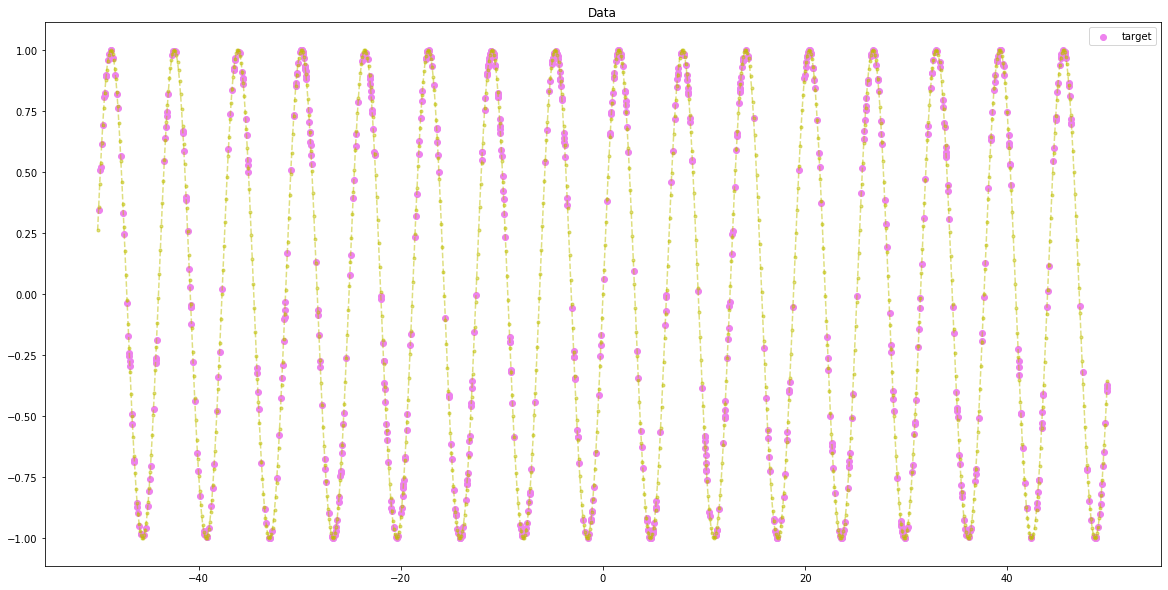

In [32]:
import csv

params = {}
a = 1 ; b = 1 ; c = 0 ; d = 0

period = math.pi * 2

params['a'] = a ; params['b'] = b ; params['c'] = c ; params['d'] = d

Maximum= 50; Minimum = -50

clipped = np.arange(-1,1.5,0.5)

X_test, Y_test = get_Sin_Data(count=1000, a=1, b=1, c=0, d=0)

with open('Architecture_Search3.csv','w', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(['experiment number', 'portion1', 'portion2', 'portion3', 'portion4', 'model_name', 'loss'])
    
    for i in range(10):
        portions = [random.randint(0,500) for _ in range(4)]
        total = sum(portions)
        for j in range(len(portions)):
            portions[j] = round(portions[j]/total,2)
            
        X_train, Y_train = mixed_data(count=1000, portions=portions)
        print(portions)
        plotData(X_train, Y_train, period, params=params, model=None, title_name="Data")

        for l in hidden_layers:
            for n in hidden_neurons:
                model, _ = buildFCModel(input_shape=(1,), hidden_layers=l, hidden_neurons=n)
                history = model.fit(X_train % period, Y_train, batch_size=50, epochs=100, validation_data=(X_test % period,Y_test), verbose=0)
                
                loss = history.history['val_loss'][-1]
                
                model_name = '( '+ str(l) +', ' + str(n) + ' )'
                wr.writerow([i, portions[0], portions[1], portions[2], portions[3], model_name, loss])

### Visualize Result

In [35]:
import pandas as pd
result = pd.read_csv('./Architecture_Search3.csv')
print(result)

     experiment number  portion1  portion2  portion3  portion4   model_name  \
0                    0      0.07      0.32      0.31      0.29    ( 2, 32 )   
1                    0      0.07      0.32      0.31      0.29    ( 2, 64 )   
2                    0      0.07      0.32      0.31      0.29   ( 2, 128 )   
3                    0      0.07      0.32      0.31      0.29   ( 2, 256 )   
4                    0      0.07      0.32      0.31      0.29    ( 4, 32 )   
5                    0      0.07      0.32      0.31      0.29    ( 4, 64 )   
6                    0      0.07      0.32      0.31      0.29   ( 4, 128 )   
7                    0      0.07      0.32      0.31      0.29   ( 4, 256 )   
8                    0      0.07      0.32      0.31      0.29    ( 8, 32 )   
9                    0      0.07      0.32      0.31      0.29    ( 8, 64 )   
10                   0      0.07      0.32      0.31      0.29   ( 8, 128 )   
11                   0      0.07      0.32      0.31

In [36]:
data = result['loss'].groupby([result['experiment number'], result['portion1'], result['portion2'], result['portion3'], result['portion4']]).mean()
print(data)

experiment number  portion1  portion2  portion3  portion4
0                  0.07      0.32      0.31      0.29        0.037935
1                  0.34      0.34      0.16      0.16        0.016769
2                  0.11      0.36      0.11      0.43        0.032953
3                  0.23      0.47      0.27      0.04        0.033591
4                  0.09      0.52      0.24      0.15        0.036963
5                  0.04      0.41      0.28      0.26        0.045096
6                  0.42      0.18      0.19      0.21        0.016025
7                  0.14      0.06      0.39      0.42        0.033166
8                  0.36      0.15      0.33      0.17        0.018395
9                  0.27      0.14      0.05      0.54        0.024388
Name: loss, dtype: float64


In [79]:
loss_result = result['loss'].groupby([result['# hidden layers'], result['# hidden neurons']]).mean()
loss_result = loss_result.unstack()
print(loss_result)

# hidden neurons       32        64        128       256
# hidden layers                                         
2                 0.103278  0.083133  0.061427  0.039655
4                 0.050622  0.025918  0.005121  0.001872
8                 0.017353  0.000391  0.000129  0.000541
16                0.000513  0.000111  0.000975  0.000180


In [80]:
parameters_result = result['# parameters'].groupby([result['# hidden layers'], result['# hidden neurons']]).mean()
parameters_result = parameters_result.unstack()
print(parameters_result)

# hidden neurons    32     64      128      256
# hidden layers                                
2                  2209   8513   33409   132353
4                  4321  16833   66433   263937
8                  8545  33473  132481   527105
16                16993  66753  264577  1053441


#### hidden neuron 증가에 따른 변화

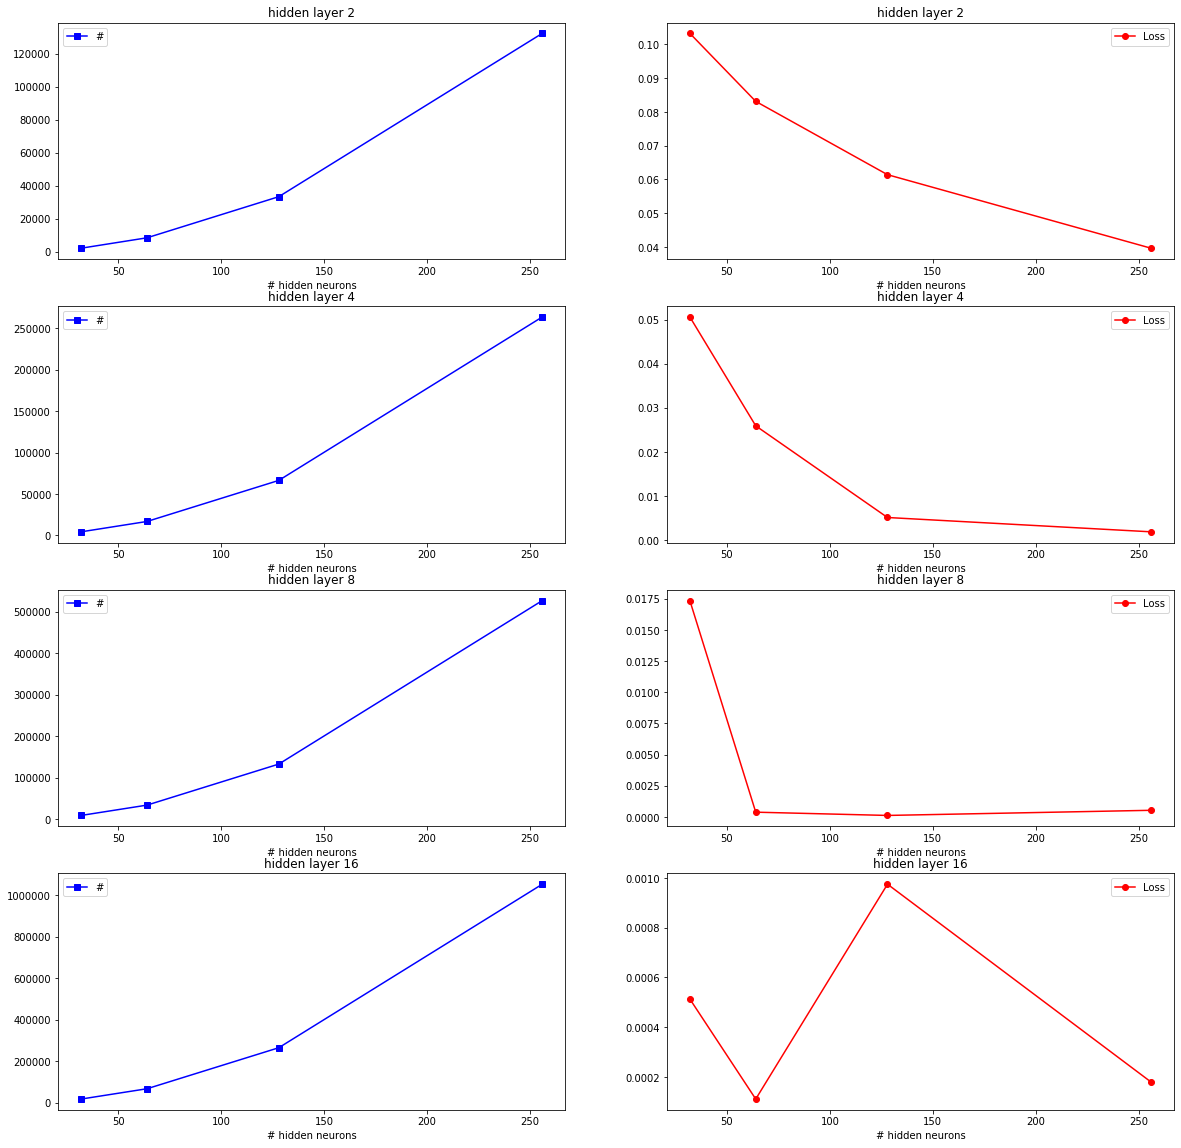

In [81]:
plt.figure(figsize=(20, 20))
position = 421
for l in hidden_layers:
    plt.subplot(position)
    loss_data = []
    param_data = []
    
    for n in hidden_neurons:
        loss_data.append(loss_result.loc[l][n])
        param_data.append(parameters_result.loc[l][n])
 
    plt.plot(hidden_neurons, param_data, 'bs-', label="Number of Parameters")
    plt.xlabel("# hidden neurons")
    plt.legend("# parameters")
    plt.title("hidden layer "+ str(l))
    position += 1
    
    plt.subplot(position)
    plt.plot(hidden_neurons, loss_data, 'ro-', label="Loss")
    plt.xlabel("# hidden neurons")
    plt.legend("# parameters")
    plt.legend()
    plt.title("hidden layer "+ str(l))
    position += 1 
    
plt.show()
plt.close()

### layer 증가에 따른 변화

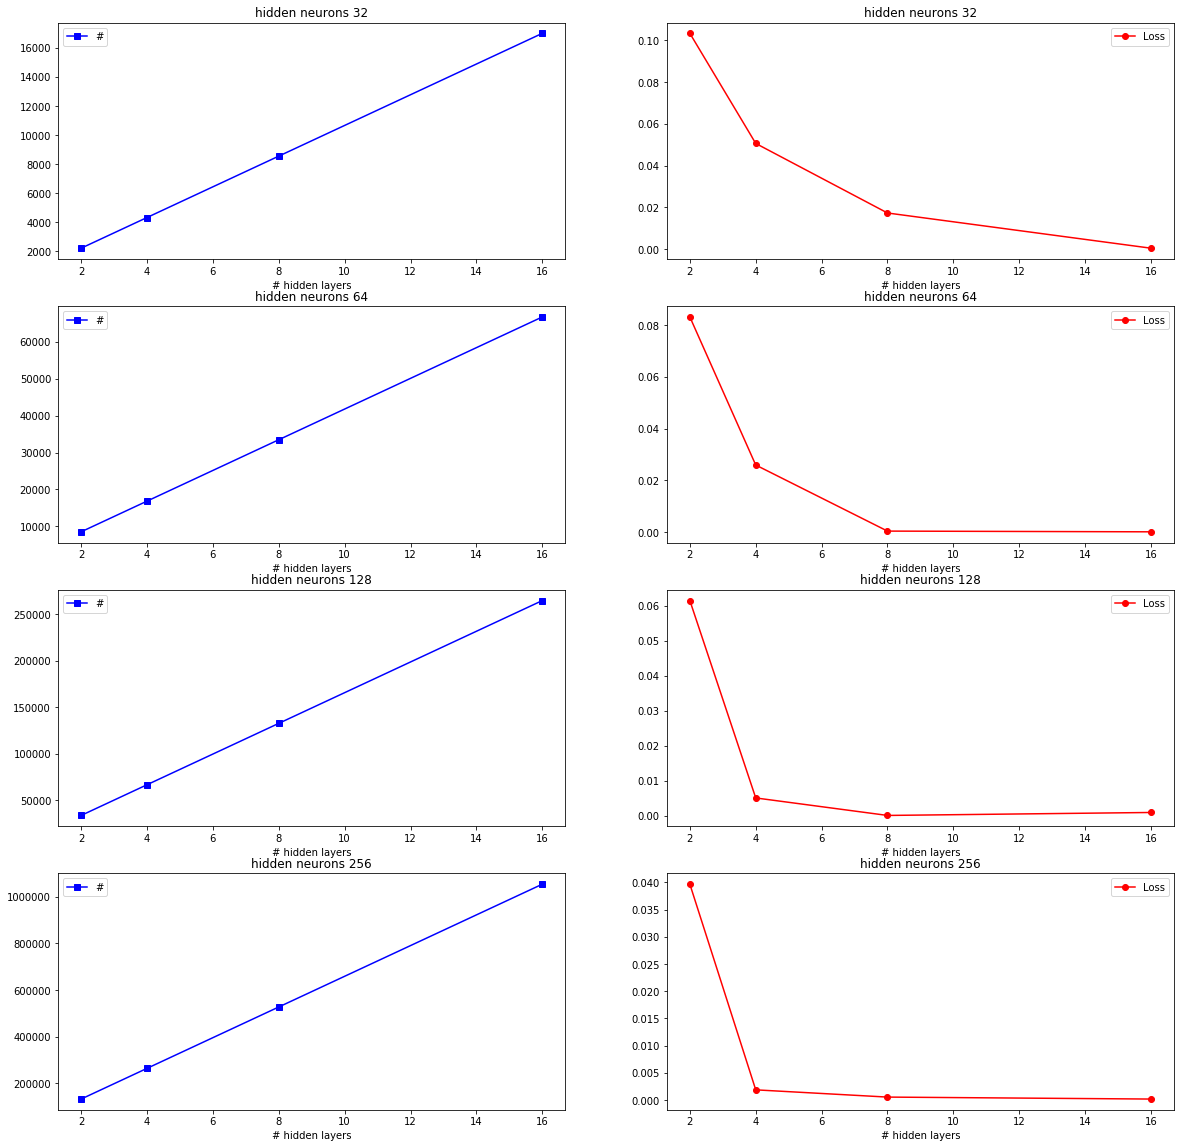

In [82]:
total_loss = []
total_parameters = []

plt.figure(figsize=(20, 20))
position = 421
for n in hidden_neurons:
    plt.subplot(position)
    loss_data = []
    param_data = []
    
    for l in hidden_layers:
        loss_data.append(loss_result.loc[l][n])
        param_data.append(parameters_result.loc[l][n])
        total_loss.append(loss_result.loc[l][n])
        total_parameters.append(parameters_result.loc[l][n])
 
    plt.plot(hidden_layers, param_data, 'bs-', label="Number of Parameters")
    plt.xlabel("# hidden layers")
    plt.legend("# parameters")
    plt.title("hidden neurons "+ str(n))
    position += 1
    
    plt.subplot(position)
    plt.plot(hidden_layers, loss_data, 'ro-', label="Loss")
    plt.xlabel("# hidden layers")
    plt.legend("# parameters")
    plt.legend()
    plt.title("hidden neurons "+ str(n))
    position += 1 

plt.show()
plt.close()

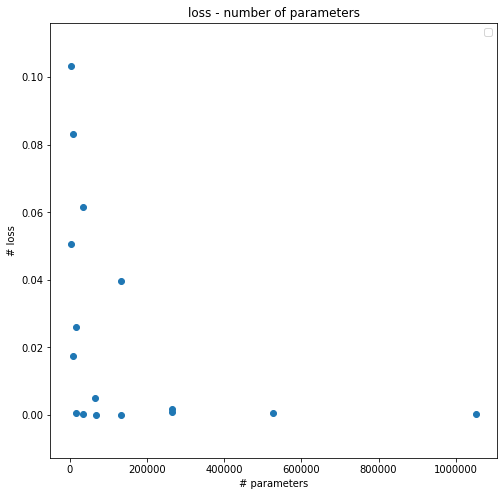

In [83]:
plt.figure(figsize=(8, 8))
total_parameters = np.array(total_parameters)
total_loss = np.array(total_loss)

idx = np.argsort(total_parameters)
total_parameters = total_parameters[idx]
total_loss = total_loss[idx]

plt.scatter(total_parameters, total_loss)
plt.xlabel("# parameters")
plt.ylabel("# loss")
plt.legend()
plt.title("loss - number of parameters")
plt.show()
plt.close()